In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data.csv')

### Adding into db for easy retrieval

In [3]:
import sqlite3
from sqlalchemy import create_engine
to_store = pd.DataFrame(data={'Date': df.index, 'Close': d['Close']})
engine = create_engine('sqlite:///spindex.db')
to_store.to_sql('close_price', engine, if_exists='replace', index=False)
engine.dispose()
connect = sqlite3.connect('spindex.db')
cursor = connect.cursor()
result = cursor.execute('Select * from close_price limit 10')
result.fetchall()

NameError: name 'monthly' is not defined

# SVR

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [2]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
2,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000
3,1990-04-01,339.940002,347.299988,327.760010,330.799988,330.799988,2801220000
4,1990-05-01,330.799988,362.260010,330.799988,361.230011,361.230011,3596680000


In [3]:
svr_data = df[['Date', 'Close']]

In [4]:
svr_data.head()

,Date,Close
0,1990-01-01,329.079987
1,1990-02-01,331.890015
2,1990-03-01,339.940002
3,1990-04-01,330.799988
4,1990-05-01,361.230011


In [5]:
svr_data = df.copy(deep=True)
svr_data.set_index('Date', inplace=True)
svr_data = svr_data[['Close']]
svr_data = svr_data.diff().diff()
svr_data.dropna(inplace=True)
svr_data.head()

,Close
Date,
1990-03-01,5.239960
1990-04-01,-17.190002
1990-05-01,39.570038
1990-06-01,-33.640045
1990-07-01,1.340027


In [134]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from warnings import filterwarnings
filterwarnings('ignore')
svr = LinearSVR()
X = svr_data['Date'].values.astype(np.float32)
X = X.reshape(-1, 1)
y = svr_data['Close'].values
folds = KFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'C':[1, 10], 'max_iter':[1000, 20000]} #The parameters to tune for this model. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
svr_tuned = GridSearchCV(svr, parameters)
svr_tuned.fit(X_train, y_train)
kfscore = cross_val_score(svr_tuned, X_train, y_train, cv=folds, scoring='neg_mean_absolute_error')
print("Outer Cross-Validation Scores:", kfscore)
print("Average Outer Cross-Validation Score:", np.abs(np.mean(kfscore)))
y_pred = svr_tuned.predict(X_test)
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(y_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(y_test, y_pred)}\nR2 Score: {r2_score(y_test, y_pred)}')

Outer Cross-Validation Scores: [-1763.57848542 -1451.47785042 -1528.75768926 -1697.8580694
 -1656.30384201]
Average Outer Cross-Validation Score: 1619.595187298689
The evaluations are as follows
Mean Squared Error: 4965373.668902173
Mean Absolute Error: 1846.3290477934338
R2 Score: -2.1902064992795607


In [135]:
to_save = pd.DataFrame({'Date':pd.to_datetime(X_test.reshape(-1,)), 'Actual':y_test, 'Predicted':y_pred})
to_save.to_csv('svr.csv')
import pickle
with open('svr.pkl', 'wb') as file:
    pickle.dump(svr, file)

# ETS

In [136]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [137]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1990-01-01,329.079987
1,1990-02-01,331.890015
2,1990-03-01,339.940002
3,1990-04-01,330.799988
4,1990-05-01,361.230011


In [138]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
series = pd.Series(data=df['Close'].values, index=df['Date'])
size = int(len(series) * 0.95)
train = series.iloc[:size]
test = series.iloc[size:]
X_train, X_test = train.index.values, test.index.values
y_train, y_test = train.values, test.values

In [139]:
model = ExponentialSmoothing(train, trend='add', seasonal=None)
fit = model.fit(smoothing_level=0.3, smoothing_trend=0.05, smoothing_seasonal=0.04)

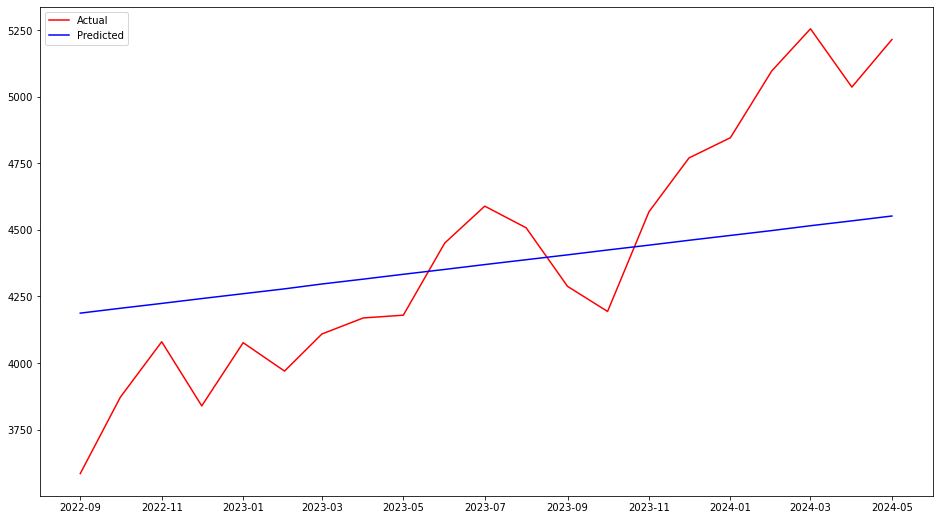

In [140]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(X_test, y_test, 'red', label='Actual')
plt.plot(X_test, fit.forecast(X_test.shape[0]).values, 'blue', label="Predicted")
plt.legend()
plt.show()

In [141]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = fit.forecast(X_test.shape[0])
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(y_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(y_test, y_pred)}\nR2 Score: {r2_score(y_test, y_pred)}')

The evaluations are as follows
Mean Squared Error: 135493.03753114867
Mean Absolute Error: 311.92396236930784
R2 Score: 0.3787153998565972


In [142]:
to_save = pd.DataFrame({'Date':series.index.values[-y_pred.shape[0]:], 'Actual':y_test, 'Predicted':y_pred})
to_save.to_csv('ets.csv')

In [144]:
import pickle
fit.save('ets.pkl')

# Prophet

In [145]:
from prophet import Prophet

In [146]:
model = Prophet(yearly_seasonality=True, n_changepoints=50, seasonality_prior_scale=800, changepoint_prior_scale=10, seasonality_mode='multiplicative', interval_width=0.90)
model.fit(pd.DataFrame({'ds':X_train, 'y':y_train}))
future = model.make_future_dataframe(periods=len(X_test), freq='M')
forecast = model.predict(future)

18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
future.shape

(413, 1)

In [148]:
forecast = forecast.tail(len(X_test))[['ds', 'yhat']]
forecast

,ds,yhat
392,2022-08-31,4407.643959
393,2022-09-30,4781.359661
394,2022-10-31,4630.147661
395,2022-11-30,4448.186207
396,2022-12-31,4330.208549
397,2023-01-31,3935.629676
398,2023-02-28,5274.341444
399,2023-03-31,4727.376674
400,2023-04-30,4443.993326
401,2023-05-31,4452.740147


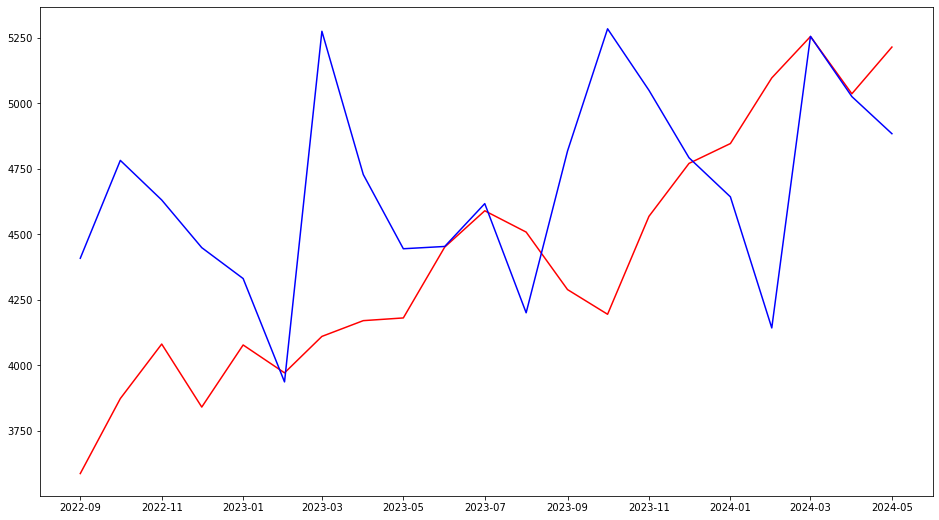

In [149]:
plt.figure(figsize=(16,9))
plt.plot(X_test, y_test, 'red', label='Training')
plt.plot(X_test, forecast['yhat'].values, 'blue', label="Testing")
plt.show()

In [150]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = forecast['yhat']
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(y_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(y_test, y_pred)}\nR2 Score: {r2_score(y_test, y_pred)}')

The evaluations are as follows
Mean Squared Error: 325596.0626422685
Mean Absolute Error: 434.53149250306717
R2 Score: -0.49297575191244736


In [151]:
to_save = pd.DataFrame({'Date':forecast['ds'].values, 'Actual':y_test, 'Predicted':y_pred})
to_save.to_csv('Prophet.csv')

In [153]:
from prophet.serialize import model_to_json
with open('prophet.json', 'w') as fout:
    fout.write(model_to_json(model))